# QN durs

In [122]:
%reload_ext autoreload
%autoreload 2

import os
import nemo
import copy
import tqdm
import timeit
import shutil
import pathlib
import attrdict
import itertools
import numpy as np
import matplotlib.pyplot as plt

from ruamel import yaml
from Bio import pairwise2
from nemo.collections.asr import helpers
from nemo.collections import asr as nemo_asr

## Initial infer

In [93]:
DATA = pathlib.Path('~/data').expanduser()
# Checkpoint of QuartzNet trained in NeMo with first layer's stride set to 1.
# https://ngc.nvidia.com/datasets/iDeVV83pQPOZezEC8WHWVg
NGC_CKPT = DATA / 'ckpts/nemo-qn15x5-stride1-libritts'
# Dataset to infer for (structure should comply with NeMo)
DATASET = DATA / 'libritts/local/dev-clean.json'

In [94]:
NGC_CKPT0 = NGC_CKPT / '0/QuartzNet-lr_0.01-bs_32-e_300-wd_0.001-opt_novograd'
yaml_loader = yaml.YAML(typ='safe')
with open(NGC_CKPT0 / 'quartznet15x5s1sr24_2020-07-01_08-06-19.yaml') as f:
    config = attrdict.AttrDict(yaml_loader.load(f))

nemo.core.NeuralModuleFactory(placement=nemo.core.DeviceType.GPU)
data_layer = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=str(DATASET),
    sample_rate=config.sample_rate,
    labels=config.labels,
    batch_size=64,
    shuffle=False,
)

[NeMo I 2020-07-03 05:54:58 collections:158] Dataset loaded with 5736 files totalling 8.97 hours
[NeMo I 2020-07-03 05:54:58 collections:159] 0 files were filtered totalling 0.00 hours


In [95]:
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(
    sample_rate=config.sample_rate,
    **config.AudioToMelSpectrogramPreprocessor
)
jasper_encoder = nemo_asr.JasperEncoder(
    feat_in=config.AudioToMelSpectrogramPreprocessor["features"],
    **config.JasperEncoder
)
jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=config.JasperEncoder["jasper"][-1]["filters"],
    num_classes=len(config.labels)
)
greedy_decoder = nemo_asr.GreedyCTCDecoder()

audio_signal_e1, a_sig_length_e1, transcript_e1, transcript_len_e1 = data_layer()
processed_signal_e1, p_length_e1 = data_preprocessor(input_signal=audio_signal_e1, length=a_sig_length_e1)
encoded_e1, encoded_len_e1 = jasper_encoder(audio_signal=processed_signal_e1, length=p_length_e1)
log_probs_e1 = jasper_decoder(encoder_output=encoded_e1)
predictions_e1 = greedy_decoder(log_probs=log_probs_e1)

[NeMo I 2020-07-03 05:54:58 features:144] PADDING: 16
[NeMo I 2020-07-03 05:54:58 features:152] STFT using conv


In [96]:
eval_tensors = [
    log_probs_e1, predictions_e1, transcript_e1, transcript_len_e1, 
    encoded_len_e1, processed_signal_e1, p_length_e1,
]
evaluated_tensors = runner.infer(
    tensors=eval_tensors,
    checkpoint_dir=str(NGC_CKPT0 / 'checkpoints'),
)

[NeMo I 2020-07-03 05:54:58 actions:1549] Restoring JasperEncoder from /home/stanislavv/data/ckpts/nemo-qn15x5-stride1-libritts/0/QuartzNet-lr_0.01-bs_32-e_300-wd_0.001-opt_novograd/checkpoints/JasperEncoder-STEP-100808.pt
[NeMo I 2020-07-03 05:54:58 actions:1549] Restoring JasperDecoderForCTC from /home/stanislavv/data/ckpts/nemo-qn15x5-stride1-libritts/0/QuartzNet-lr_0.01-bs_32-e_300-wd_0.001-opt_novograd/checkpoints/JasperDecoderForCTC-STEP-100808.pt
[NeMo I 2020-07-03 05:54:59 actions:683] Evaluating batch 0 out of 90
[NeMo I 2020-07-03 05:55:05 actions:683] Evaluating batch 9 out of 90
[NeMo I 2020-07-03 05:55:13 actions:683] Evaluating batch 18 out of 90
[NeMo I 2020-07-03 05:55:22 actions:683] Evaluating batch 27 out of 90
[NeMo I 2020-07-03 05:55:29 actions:683] Evaluating batch 36 out of 90
[NeMo I 2020-07-03 05:55:37 actions:683] Evaluating batch 45 out of 90
[NeMo I 2020-07-03 05:55:44 actions:683] Evaluating batch 54 out of 90
[NeMo I 2020-07-03 05:55:53 actions:683] Evalua

In [121]:
references = helpers.post_process_transcripts(evaluated_tensors[2], evaluated_tensors[3], config.labels)
greedy_hypotheses = helpers.post_process_predictions(evaluated_tensors[1], config.labels)
denorm_hypot = []
for t in greedy_hypotheses:
    for c in ',.!?':
        t = t.replace(f' {c}', c)
    denorm_hypot.append(t)
helpers.word_error_rate(denorm_hypot, references)  # WER

0.16278741712512343

In [98]:
references = helpers.post_process_transcripts(evaluated_tensors[2], evaluated_tensors[3], config.labels)
greedy_hypotheses = helpers.post_process_predictions(evaluated_tensors[1], config.labels)
helpers.word_error_rate(greedy_hypotheses, references, use_cer=True)  # CER

0.06151288139092478

## Logic

In [46]:
labels = list(config.labels)
print(*labels)

  a b c d e f g h i j k l m n o p q r s t u v w x y z , . ! ? ; : - " ' ( ) [ ]


In [123]:
text = evaluated_tensors[2][0]
text_len = evaluated_tensors[3][0]
ctc_tokens = evaluated_tensors[1][0]
ctc_logprobs = evaluated_tensors[0][0]
ctc_len = evaluated_tensors[4][0]
mel_len = evaluated_tensors[-1][0]
text1 = text[0].numpy()
text_len1 = text_len[0].numpy().item()
ctc_tokens1 = ctc_tokens[0].numpy()
ctc_logprobs1 = ctc_logprobs[0].numpy()
ctc_len1 = ctc_len[0].numpy().item()
mel_len1 = mel_len[0].numpy().item()
text1 = list(text1[:text_len1])
ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
len(text1), len(ctc_tokens1), ctc_logprobs1.shape

(147, 1120, (1120, 41))

In [135]:
ctc_labels = ['_'] + labels[1:] + ['~']
print('GT:', *(ctc_labels[c] for c in text1))
print('CTC:', *(ctc_labels[c] for c, _ in itertools.groupby(ctc_tokens1)))

GT: s e e , _ b e n e a t h _ y o u r _ f e e t _ i s _ t h e _ m a r k i n g _ o f _ g r e a t _ t r e e _ t r u n k s _ l y i n g _ a s l a n t _ a c r o s s _ t h e _ f l o o r , _ a n d _ t h e _ f o r m s _ o f _ g i g a n t i c _ p a l m _ l e a v e s _ s t r e w e d _ a m o n g _ t h e m .
CTC: ~ s ~ e ~ e ~ _ b ~ e ~ n ~ e ~ a t h ~ _ y ~ o u ~ r ~ _ f ~ e ~ e ~ t ~ _ ~ i ~ s ~ _ t h e ~ _ ~ m ~ a ~ r k ~ i ~ n g ~ _ ~ o ~ f ~ _ g r e a ~ t ~ _ t r e ~ e ~ _ t r u ~ n k s ~ _ l ~ y ~ i ~ n g ~ _ ~ a ~ s l ~ a ~ n t ~ _ ~ a ~ c r o ~ s ~ s ~ _ t h e ~ _ f l o ~ o r ~ _ , _ ~ a ~ n d ~ _ t h e ~ _ f ~ o ~ r ~ m ~ s ~ _ ~ o ~ f ~ _ g ~ i ~ g ~ a ~ n t ~ i ~ c ~ _ p ~ a ~ l ~ m ~ _ l ~ e ~ a ~ v e s ~ _ s t r o ~ d e d ~ _ ~ a ~ m ~ o ~ n g ~ _ t h ~ i ~ m ~ _ . ~


In [124]:
bs = np.exp(ctc_logprobs1[:, -1])
best_nb = np.exp(ctc_logprobs1[:, :-1].max(-1))
probs = ctc_logprobs1[:, :-1]
probs.sort()
best2_nb = np.exp(probs[:, -2])

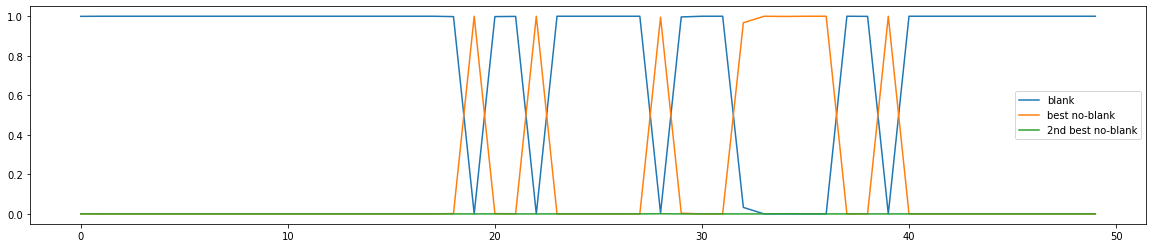

In [125]:
plt.figure(figsize=(20, 4))
plt.plot(bs[:50], label='blank')
plt.plot(best_nb[:50], label='best no-blank');
plt.plot(best2_nb[:50], label='2nd best no-blank');
plt.legend();

In [126]:
class PadProcesser:
    def __init__(self, labels):
        labels = labels + ['~']
        self.blank_id = len(labels) - 1
        self.space_id = labels.index(' ')
        self.labels_map = dict([(i, labels[i]) for i in range(len(labels))])
    
    def bound_text(self, tokens):
        return [self.space_id] + tokens + [self.space_id]
    
    def bound_ctc(self, tokens, logprobs):
        tokens = [self.space_id, self.blank_id] + tokens + [self.blank_id, self.space_id]
        
        logprobs = np.lib.pad(logprobs, ((2, 2), (0, 0)), 'edge')

        def swap(col, a, b):
            logprobs[col][a], logprobs[col][b] = logprobs[col][b], logprobs[col][a]
        
        first_token, last_token = tokens[2], tokens[-3]
        swap(0, first_token, self.space_id)
        swap(1, first_token, self.blank_id)
        swap(-1, last_token, self.space_id)
        swap(-2, last_token, self.blank_id)

        return tokens, logprobs
    
    def merge(self, tokens):
        output_tokens = []
        output_cnts = []
        cnt = 0
        for i in range(len(tokens)):
            if i != 0 and (tokens[i - 1] != tokens[i]):
                output_tokens.append(tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += 1

        output_tokens.append(tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == len(tokens), f'SUM_CHECK {sum(output_cnts)} vs {len(tokens)}'

        return output_tokens, output_cnts
    
    def merge_with_blanks(self, tokens, cnts, logprobs=None):
        def choose_sep(l, r, a, b):
            # `tokens[l] == a and tokens[r] == b`.
            sum_a, sum_b = logprobs[l, a], logprobs[l + 1:r + 1, b].sum()
            best_sum, best_sep = sum_a + sum_b, 0
            for sep in range(1, r - l):
                sum_a += logprobs[l + sep, a]
                sum_b -= logprobs[l + sep, b]
                if sum_a + sum_b > best_sum:
                    best_sum, best_sep = sum_a + sum_b, sep

            return best_sep
        
        output_tokens = []
        output_durs = []
        blank_cnt = 0
        total_cnt = 0
        for token, cnt in zip(tokens, cnts):
            total_cnt += cnt
            if token == self.blank_id:
                blank_cnt += cnt
                continue
            
            output_tokens.append(token)
            
            if logprobs is None:
                # Half half.
                left_cnt = blank_cnt // 2
            else:
                # Clever sep choice based on sum of log probs.
                left_cnt = choose_sep(
                    l=total_cnt - cnt - blank_cnt - 1,
                    r=total_cnt - cnt,
                    a=output_tokens[-1],
                    b=token,
                )
            right_cnt = blank_cnt - left_cnt
            blank_cnt = 0
            
            if left_cnt:
                output_durs[-1] += left_cnt
            output_durs.append(cnt + right_cnt)
        
        output_durs[-1] += blank_cnt

        assert sum(output_durs) == sum(cnts), f'SUM_CHECK {sum(output_durs)} vs {sum(cnts)}'

        return output_tokens, output_durs
    
    def align(self, output_tokens, gt_text):
        def make_str(tokens):
            return ''.join(self.labels_map[c] for c in tokens)
        
        s = make_str(output_tokens)
        t = make_str(gt_text)
        alignmet = pairwise2.align.globalxx(s, t, gap_char='%')[0]
        sa, ta, *_ = alignmet
        return sa, ta
    
    def generate(self, gt_text, alignment, durs):
        output_tokens = []
        output_cnts = []
        si, ti = 0, 0
#         print(len(durs))
        assert len(alignment[0]) == len(alignment[1])
        for sc, tc in zip(*alignment):
#             print(si, sc, ti, tc)
            if sc == '%' and tc == '%':
                print('NO WAY')
                continue
            
            if sc == '%':
                output_tokens.append(self.blank_id)
                output_cnts.append(durs[si])
                si += 1
            elif tc == '%':
                output_tokens.append(gt_text[ti])
                output_cnts.append(0)
                ti += 1
            else:
                output_tokens.append(gt_text[ti])
                output_cnts.append(durs[si])
                si += 1
                ti += 1

        assert sum(output_cnts) == sum(durs)
        
        return output_tokens, output_cnts

    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        # This adds +2 tokens.
        text = self.bound_text(text)
        # This add +4 tokens, 2 of them are blank.
        ctc_tokens, ctc_logprobs = self.bound_ctc(ctc_tokens, ctc_logprobs)

        ctc_tokens, ctc_cnts = self.merge(ctc_tokens)
        ctc_tokens, ctc_durs = self.merge_with_blanks(ctc_tokens, ctc_cnts, ctc_logprobs)
        
        alignment = self.align(text, ctc_tokens)
        tokens, cnts = self.generate(text, alignment, ctc_durs)
        tokens, durs = self.merge_with_blanks(tokens, cnts)
        assert tokens == text, 'EXACT_TOKENS_MATCH_CHECK'

        def adjust(start, direction, value):
            i = start
            while value != 0:
                dur = durs[i]
                
                if value < 0:
                    durs[i] = dur - value
                else:
                    durs[i] = max(dur - value, 0)
                
                value -= dur - durs[i]
                i += direction

        adjust(0, 1, 4)
        adjust(-1, -1, sum(durs) - mel_len)  # Including 4 suffix bound tokens.
        assert durs[0] >= 0, f'{durs[0]}'
        assert durs[-1] >= 0, f'{durs[-1]}'
        
        durs = np.array(durs, dtype=np.long)
        assert durs.shape[0] == len(text), f'LEN_CHECK {durs.shape[0]} vs {len(text)}'
        assert np.sum(durs) == mel_len, f'SUM_CHECK {np.sum(durs)} vs {mel_len}'

        return durs

processer = PadProcesser(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

array([ 0, 18,  3,  6,  0,  7,  1,  3, 14,  2,  8,  1,  2, 14,  1,  3,  1,
        6, 17,  1,  8,  5,  1, 31,  4,  4, 10,  1,  2,  5,  9,  3,  3, 10,
        2, 12,  2,  1, 30,  3,  5, 28,  1,  2,  1,  2,  8, 24,  1,  2, 10,
       14,  9,  1,  2, 13,  1,  1,  3, 43,  1, 10, 10,  1,  1, 10, 10, 16,
        2, 10,  7,  1, 27, 18,  2,  2,  2,  8,  5, 12,  1,  2,  1, 16,  1,
        2,  1, 13, 84, 22,  6,  3,  3,  1,  5,  1,  2,  2, 14,  1,  4, 13,
        2,  4, 29,  4,  8, 11,  1,  3, 26,  8,  9,  1,  9, 14, 10,  1,  3,
        9,  7, 11,  1,  3,  8,  2,  2,  3, 28,  1,  1,  2,  0,  7,  8,  5,
       26,  2, 10,  3,  7,  1, 14,  1,  1,  1, 18, 14,  3])

In [127]:
class Seq:
    def __init__(self, tokens, cnts=None):
        if cnts is None:
            cnts = np.ones(len(tokens), dtype=np.long)

        assert len(tokens) == len(cnts)
        self.tokens = tokens
        self.cnts = cnts
    
    def __repr__(self):
        return repr(list(zip(self.tokens, self.cnts)))
    
    @property
    def total(self):
        return sum(self.cnts)
    
    def merge(self):
        output_tokens = []
        output_cnts = []
        
        cnt = 0
        for i in range(len(self.tokens)):
            if i != 0 and (self.tokens[i - 1] != self.tokens[i]):
                output_tokens.append(self.tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += self.cnts[i]

        output_tokens.append(self.tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == sum(self.cnts), \
            f'SUM-CHECK {sum(output_cnts)} vs {sum(self.cnts)}'

        return Seq(output_tokens, output_cnts)
    
    def full_pad(self, blank_id, blank_cnt=1):
        output_tokens = [blank_id]
        output_cnts = [blank_cnt]

        for token, cnt in zip(self.tokens, self.cnts):
            output_tokens.append(token)
            output_cnts.append(cnt)
            
            output_tokens.append(blank_id)
            output_cnts.append(blank_cnt)
        
        return Seq(output_tokens, output_cnts)
    
    def adjust_cnt(self, value, start=-1, direction='left'):
        tokens, cnts = self.tokens, self.cnts.copy()
        
        i, di = start, -1 if direction == 'left' else 1
        while value != 0:
            cnt = cnts[i]

            if value < 0:
                cnts[i] = cnt - value
            else:
                cnts[i] = max(cnt - value, 0)

            value -= cnt - cnts[i]
            i += di
        
        return Seq(tokens, cnts)
    
    def split2(self):
        tokens1, cnts1 = [], []
        tokens2, cnts2 = [], []
        turn = 1
        
        for token, cnt in zip(self.tokens, self.cnts):
            if turn == 1:
                tokens1.append(token)
                cnts1.append(cnt)
            else:
                tokens2.append(token)
                cnts2.append(cnt)
            
            turn = 1 if turn == 2 else 2
        
        return Seq(tokens1, cnts1), Seq(tokens2, cnts2)

In [133]:
class FullProcessor(PadProcesser):
    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        text = Seq(text).full_pad(self.blank_id)
        ctc = Seq(ctc_tokens).merge().full_pad(self.blank_id, blank_cnt=0).merge()
        
        alignment = self.align(text.tokens, ctc.tokens)
        gen = Seq(*self.generate(text.tokens, alignment, ctc.cnts)).merge()
#         gen = gen.merge().adjust_cnt(gen.total - mel_len)
        
        # Two durs conditions.
        assert gen.tokens == text.tokens
        assert gen.total == mel_len
#         assert abs(2 * gen.total - mel_len) <= 1
        
        blanks, text = gen.split2()
        blanks = np.array(blanks.cnts, dtype=np.long)
        cnts = np.array(text.cnts, dtype=np.long)
        
        assert len(blanks) == len(cnts) + 1
        
        return blanks, cnts


processer = FullProcessor(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

(array([ 19,   2,   5,   0,   3,   0,   2,  12,   2,   6,   0,   0,  10,
          0,   2,   0,   3,  16,   0,   2,   8,   1,  20,   3,   3,   5,
          0,   0,   0,  11,   1,   2,   9,   0,  10,   2,   0,  20,   3,
          3,  21,   0,   0,   0,   0,   7,  21,   0,   0,   0,   8,  18,
          0,   0,   0,  12,   0,   0,  31,   0,   9,   7,   2,   0,   7,
          3,  21,   0,   1,  13,   0,  20,   3,  15,   0,   0,   8,   1,
         12,   0,   0,   0,  13,   0,   0,   0,  11,   0, 104,   0,   3,
          2,   0,   2,   0,   0,   0,  11,   0,   2,  12,   1,   1,  23,
          3,   3,  10,   0,   2,  25,   2,  13,   0,   7,   3,  13,   0,
          2,   8,   1,  13,   0,   2,   7,   1,   0,   0,  23,   0,   0,
          0,   0,  13,   1,   0,  21,   2,   9,   2,   6,   0,  11,   0,
          0,   1,   5,  25,   1]),
 array([ 1,  1,  1,  0,  4,  1,  1,  1,  1,  2,  1,  1,  5,  1,  1,  1,  1,
         3,  1,  1,  1,  1, 11,  1,  1,  5,  1,  2,  1,  2,  1,  1,  2,  2,
         1

In [137]:
def adjust_durs(b, d):
    """Shares 1s from blanks to durs."""
    b, d, t = b.copy(), d.copy(), sum(b) + sum(d)

    doable = sum(b) >= len(d)

    for i in range(len(d)):
        if d[i] == 0:

            l, r = i, i + 1
            while True:
                if l < 0 and r >= len(b):
                    break

                if (l >= 0 and b[l] > 0) and (r >= len(b) or b[l] >= b[r]):
                    d[i] = 1
                    b[l] -= 1
                    break

                if (r < len(b) and b[r] > 0) and (l < 0 or b[r] > b[l]):
                    d[i] = 1
                    b[r] -= 1
                    break

                if l >= 0 and b[l] == 0:  # noqa
                    l -= 1  # noqa

                if r < len(b) and b[r] == 0:
                    r += 1

    assert sum(b) + sum(d) == t
    if doable:
        assert (b < 0).sum() == 0

    return (b, d), doable

## Infering all samples

In [147]:
durs_dir = DATA / 'librimeta/durs/nemo-qn15x5-stride1-libritts'
durs_dir.mkdir(exist_ok=True)

durs = []
for batch in tqdm.notebook.tqdm(zip(*evaluated_tensors), total=len(data_layer) // 64):
    text = batch[2].numpy()
    text_len = batch[3].numpy()
    ctc_tokens = batch[1].numpy()
    ctc_logprobs = batch[0].numpy()
    ctc_len = batch[4].numpy()
    mel_len = batch[-1].numpy()

    for text1, text_len1, ctc_tokens1, ctc_logprobs1, ctc_len1, mel_len1 in zip(
        text, text_len, ctc_tokens, ctc_logprobs, ctc_len, mel_len
    ):
        text1 = list(text1[:text_len1])
        ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
        ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
        mel_len1 = mel_len1.item()

        durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
        
        durs1, _ = adjust_durs(*durs1)
        assert (durs1[-1] == 0).sum() == 0
        
        durs.append(durs1)


np.save(durs_dir / 'dev-clean.npy', durs, allow_pickle=True)

/home/stanislavv/Apps/Conda/envs/stasbel-speech/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [149]:
blanks, durs = np.load(durs_dir / 'dev-clean.npy', allow_pickle=True)[0]
blanks

array([ 19,   2,   5,   0,   2,   0,   2,  12,   2,   6,   0,   0,  10,
         0,   2,   0,   3,  16,   0,   2,   8,   1,  20,   3,   3,   5,
         0,   0,   0,  11,   1,   2,   9,   0,  10,   2,   0,  20,   3,
         3,  21,   0,   0,   0,   0,   7,  21,   0,   0,   0,   8,  18,
         0,   0,   0,  12,   0,   0,  31,   0,   9,   7,   2,   0,   7,
         3,  21,   0,   1,  13,   0,  20,   3,  15,   0,   0,   8,   1,
        12,   0,   0,   0,  13,   0,   0,   0,  11,   0, 104,   0,   3,
         2,   0,   2,   0,   0,   0,  11,   0,   2,  12,   1,   1,  23,
         3,   3,  10,   0,   2,  25,   2,  13,   0,   7,   3,  13,   0,
         2,   8,   1,  13,   0,   2,   7,   1,   0,   0,  23,   0,   0,
         0,   0,  11,   1,   0,  21,   2,   9,   2,   6,   0,  11,   0,
         0,   1,   4,  25,   1])